## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from torch.utils.data import DataLoader, Dataset, Subset
from typing import Tuple, List, Type, Dict, Any
from time import time, sleep
import time
import torchvision

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules1.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

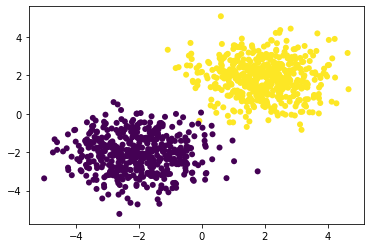

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

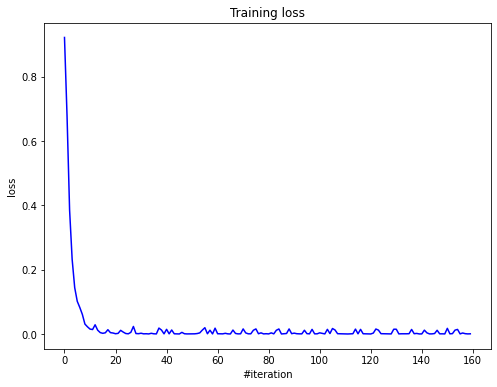

Current loss: 0.000522


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist1
X_train, y_train, X_val, y_val, X_test, y_test = mnist1.load_dataset()

In [9]:
num_classes = 10
batch_size = 256
n_epoch = 10
in_features = X_train.shape[1] * X_train.shape[1]

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################

def one_hot_encode(nb_classes, y):
    targets = y.reshape(-1)
    one_hot_targets = np.eye(nb_classes)[targets]
    return one_hot_targets

y_train_ohe = one_hot_encode(num_classes, y_train)
y_test_ohe = one_hot_encode(num_classes, y_test)
y_val_ohe = one_hot_encode(num_classes, y_val)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

### MyNet

In [11]:
# Your code goes here. ################################################

def MyNet(activation, b_norm = False):
    MyNet = Sequential()
    if b_norm == True:
        MyNet.add(Flatten())
        MyNet.add(Linear(in_features, 256))
        MyNet.add(BatchNormalization(0.2))
        MyNet[-1].moving_mean = np.zeros(256)
        MyNet[-1].moving_variance = np.ones(256)
        MyNet.add(ChannelwiseScaling(256))
        MyNet.add(activation)
        MyNet.add(Linear(256, 128))
        MyNet.add(BatchNormalization(0.2))
        MyNet[-1].moving_mean = np.zeros(128)
        MyNet[-1].moving_variance = np.ones(128)
        MyNet.add(ChannelwiseScaling(128))
        MyNet.add(activation)
        MyNet.add(Linear(128, num_classes))
        MyNet.add(LogSoftMax())
    if b_norm == False:
        MyNet.add(Flatten())
        MyNet.add(Linear(in_features, 256))
        MyNet.add(activation)
        MyNet.add(Linear(256, 128))
        MyNet.add(activation)
        MyNet.add(Linear(128, num_classes))
        MyNet.add(LogSoftMax())
    return MyNet

In [22]:
def train_loop(net, X, Y, batch_size, n_epoch, optimizer, optimizer_config, criterion = ClassNLLCriterion()):
    
    iteration_loss_history = []
    epoches_loss = []
    optimizer_state = {}
    
    for i in tqdm(np.arange(n_epoch)):
        for x_batch, y_batch in get_batches((X, Y), batch_size):
        
            net.zeroGradParameters()
        
        # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
        # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
        # Update weights
            optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
            iteration_loss_history.append(loss)
        epoches_loss.append(np.mean(iteration_loss_history))
    return iteration_loss_history, epoches_loss

In [109]:
title = 'Losses on different activation functions'
def print_losses(iter_loss, iter_loss_bn, ep_loss, ep_loss_bn, actv_name, func_name = 'BatchNorm', opt_name = '', name = title):
    fig, ax = plt.subplots(1, 2, figsize=(16,8));
    arrays = [[iter_loss, iter_loss_bn], [ep_loss, ep_loss_bn]]
    xlabel = ['Iterations', 'Epoch']
    fig.suptitle(title, y=0.93)
    for i in range(2):
        ax[i].plot(arrays[i][0], label='{} {}'.format(actv_name, opt_name))
        ax[i].plot(arrays[i][1], label='{} and {}'.format(actv_name, func_name))
        ax[i].set_xlabel(xlabel[i])
        ax[i].set_ylabel('Loss Value')
        ax[i].legend();
    print('Minimal loss: ', round(min(iter_loss), 4)) 
    print('Minimal loss with {}: '.format(func_name), round(min(iter_loss_bn), 4))

### ReLU Activation

In [23]:
#ReLU without BatchNorm
optimizer_config = {
    "learning_rate" : 1e-2,
    "momentum" : 0.9
}

net_1 = MyNet(ReLU())
iter_loss_net1, ep_loss_net1 = train_loop(net_1, X_train, y_train_ohe, batch_size, n_epoch, sgd_momentum, optimizer_config)

100%|██████████████████████████████████████████████████████████████| 10/10 [07:11<00:00, 43.16s/it]


In [24]:
#ReLU with BatchNorm
optimizer_config_bn = {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
}

net_1_bn = MyNet(ReLU(), True)
iter_loss_net1_bn, ep_loss_net1_bn = train_loop(net_1_bn, X_train, y_train_ohe, batch_size, n_epoch, sgd_momentum, optimizer_config_bn)

100%|██████████████████████████████████████████████████████████████| 10/10 [07:16<00:00, 43.65s/it]


Minimal loss:  0.0508
Minimal loss with BN:  0.001


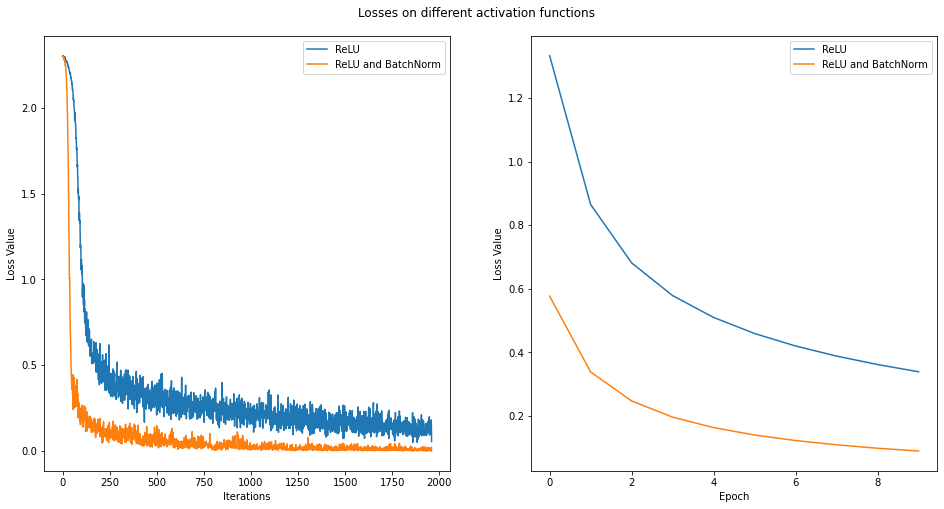

In [47]:
print_losses(iter_loss_net1, iter_loss_net1_bn, ep_loss_net1, ep_loss_net1_bn, 'ReLU')

### ELU Activation

In [48]:
#ELU
optimizer_config = {
    "learning_rate" : 1e-2,
    "momentum" : 0.9
}

net_2 = MyNet(ELU())
iter_loss_net2, ep_loss_net2 = train_loop(net_2, X_train, y_train_ohe, batch_size, n_epoch, sgd_momentum, optimizer_config)

100%|██████████████████████████████████████████████████████████████| 10/10 [07:58<00:00, 47.84s/it]


In [49]:
#ELU with BatchNorm
optimizer_config_bn = {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
}

net_2_bn = MyNet(ELU(), True)
iter_loss_net2_bn, ep_loss_net2_bn = train_loop(net_2_bn, X_train, y_train_ohe, batch_size, n_epoch, sgd_momentum, optimizer_config_bn)

100%|██████████████████████████████████████████████████████████████| 10/10 [08:31<00:00, 51.16s/it]


Minimal loss:  0.1005
Minimal loss with BN:  0.0153


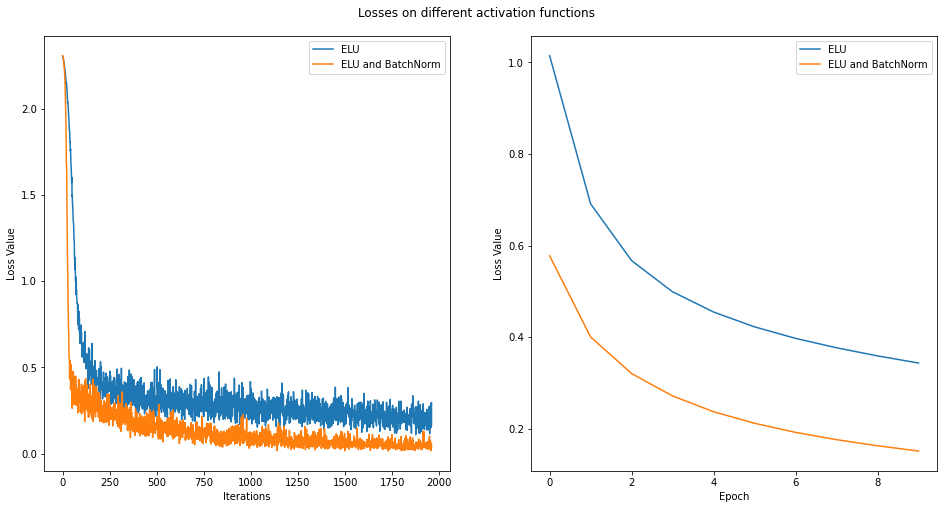

In [50]:
print_losses(iter_loss_net2, iter_loss_net2_bn, ep_loss_net2, ep_loss_net2_bn, 'ELU')

### LeakyReLU Activation

In [51]:
#LeakyReLU
optimizer_config = {
    "learning_rate" : 1e-2,
    "momentum" : 0.9
}

net_3 = MyNet(LeakyReLU())
iter_loss_net3, ep_loss_net3 = train_loop(net_3, X_train, y_train_ohe, batch_size, n_epoch, sgd_momentum, optimizer_config)

100%|██████████████████████████████████████████████████████████████| 10/10 [08:57<00:00, 53.80s/it]


In [52]:
#LeakyReLU with BatchNorm
optimizer_config_bn = {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
}

net_3_bn = MyNet(LeakyReLU(), True)
iter_loss_net3_bn, ep_loss_net3_bn = train_loop(net_3_bn, X_train, y_train_ohe, batch_size, n_epoch, sgd_momentum, optimizer_config_bn)

100%|██████████████████████████████████████████████████████████████| 10/10 [09:26<00:00, 56.67s/it]


Minimal loss:  0.0711
Minimal loss with BN:  0.0009


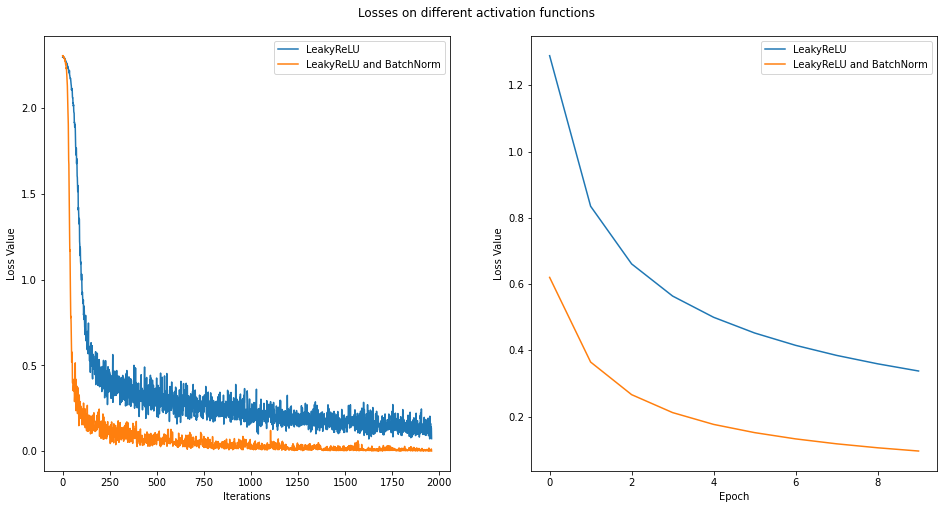

In [53]:
print_losses(iter_loss_net3, iter_loss_net3_bn, ep_loss_net3, ep_loss_net3_bn, 'LeakyReLU')

### SoftPlus Activation

In [54]:
#SoftPlus
optimizer_config = {
    "learning_rate" : 1e-2,
    "momentum" : 0.9
}

net_4 = MyNet(SoftPlus())
iter_loss_net4, ep_loss_net4 = train_loop(net_4, X_train, y_train_ohe, batch_size, n_epoch, sgd_momentum, optimizer_config)

100%|██████████████████████████████████████████████████████████████| 10/10 [08:17<00:00, 49.70s/it]


In [55]:
#SoftPlus with BatchNorm
optimizer_config_bn = {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
}

net_4_bn = MyNet(SoftPlus(), True)
iter_loss_net4_bn, ep_loss_net4_bn = train_loop(net_4_bn, X_train, y_train_ohe, batch_size, n_epoch, sgd_momentum, optimizer_config_bn)

100%|██████████████████████████████████████████████████████████████| 10/10 [08:37<00:00, 51.72s/it]


Minimal loss:  0.1369
Minimal loss with BN:  0.0143


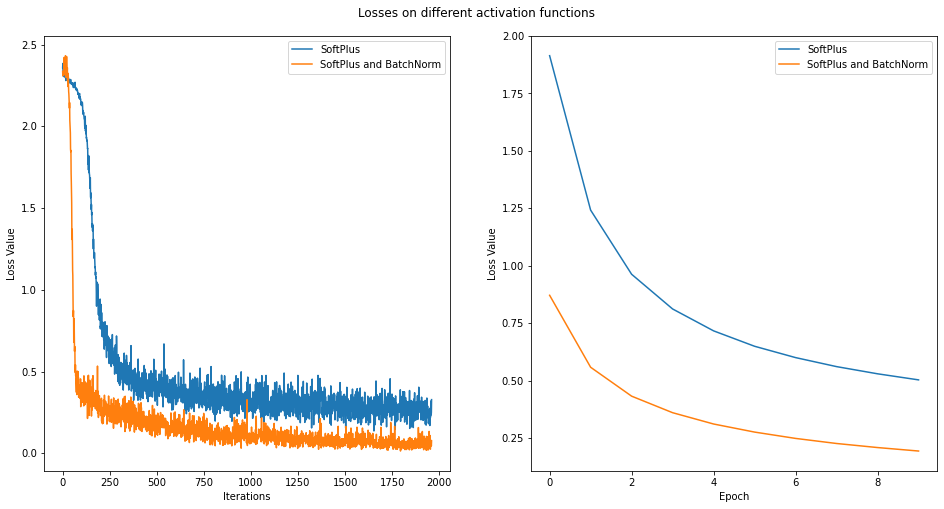

In [56]:
print_losses(iter_loss_net4, iter_loss_net4_bn, ep_loss_net4, ep_loss_net4_bn, 'SoftPlus')

### Сomparison all activations

In [57]:
iter_loss = [iter_loss_net1, iter_loss_net2, iter_loss_net3, iter_loss_net4]
iter_loss_bn = [iter_loss_net1_bn, iter_loss_net2_bn, iter_loss_net3_bn, iter_loss_net4_bn]
ep_loss = [ep_loss_net1, ep_loss_net2, ep_loss_net3, ep_loss_net4]
ep_loss_bn = [ep_loss_net1_bn, ep_loss_net2_bn, ep_loss_net3_bn, ep_loss_net4_bn]
actv_name = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']

In [104]:
def compare_losses(iter_loss, iter_loss_bn, ep_loss, ep_loss_bn, actv_name):
    fig, ax = plt.subplots(2, 1, figsize=(16,16));
    arrays = [[iter_loss, iter_loss_bn], [ep_loss, ep_loss_bn]]
    xlabel = ['Iterations', 'Epoch']
    fig.suptitle('Losses on different activation functions', y=0.9)
    for i in range(2):
        for j in range(4):
            if xlabel[i] == 'Iterations':
                ax[i].plot(gaussian_filter1d(arrays[i][0][j], 10), label='{}'.format(actv_name[j]), linestyle='--')
                ax[i].plot(gaussian_filter1d(arrays[i][1][j], 10), label='{} and BatchNorm'.format(actv_name[j]))
                ax[i].set_yscale('log')
                ax[i].set_ylabel('Loss Value in Log Scale')
            else:
                ax[i].plot(arrays[i][0][j], label='{}'.format(actv_name[j]), linestyle='--')
                ax[i].plot(arrays[i][1][j], label='{} and BatchNorm'.format(actv_name[j]))
                ax[i].set_ylabel('Loss Value')
        ax[i].set_xlabel(xlabel[i])
        ax[i].grid(which='major')
        ax[i].grid(which='minor', linestyle=':')
        ax[i].legend();

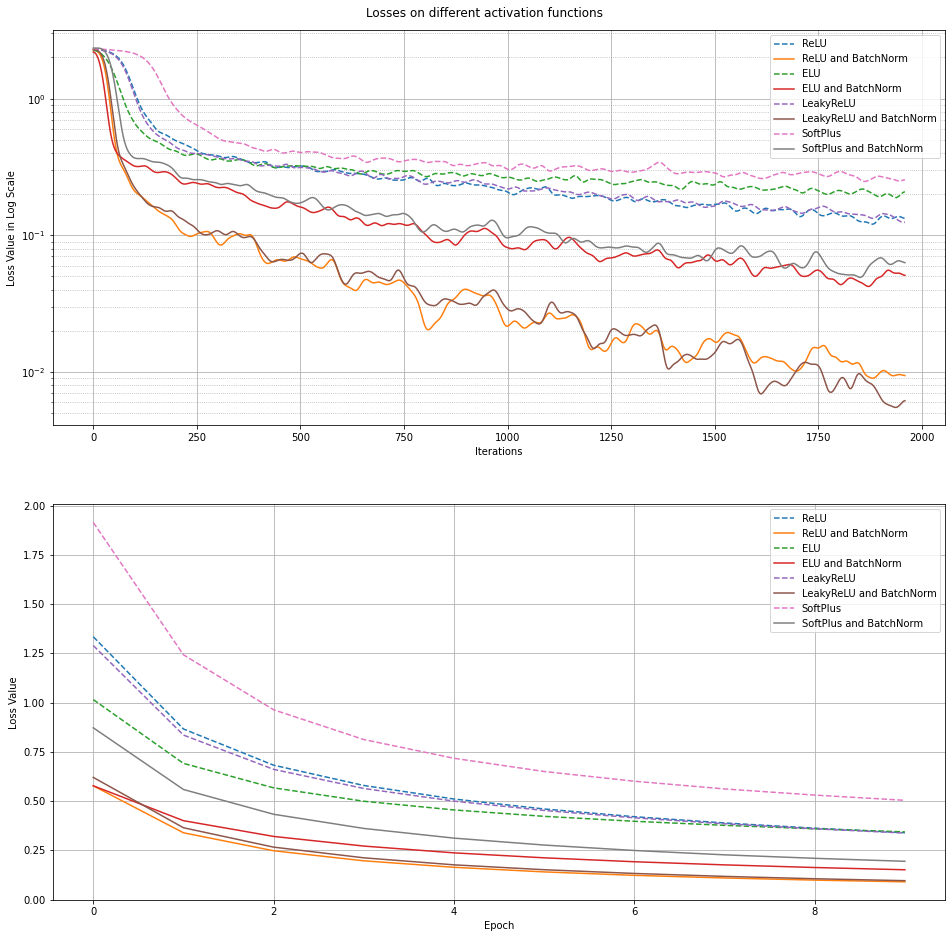

In [101]:
compare_losses(iter_loss, iter_loss_bn, ep_loss, ep_loss_bn, actv_name)

### Adam Optimizer

In [107]:
# MyNet with Adam optimizer for future compasion with best model on SGD
adam_config = {
    "learning_rate" : 5e-3,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
}

net_adam = MyNet(ReLU(), True)
iter_loss_adam, ep_loss_adam = train_loop(net_adam, X_train, y_train_ohe, batch_size, n_epoch, adam_optimizer, adam_config)

100%|██████████████████████████████████████████████████████████████| 10/10 [09:03<00:00, 54.32s/it]


Minimal loss:  0.0007
Minimal loss with Adam:  0.001


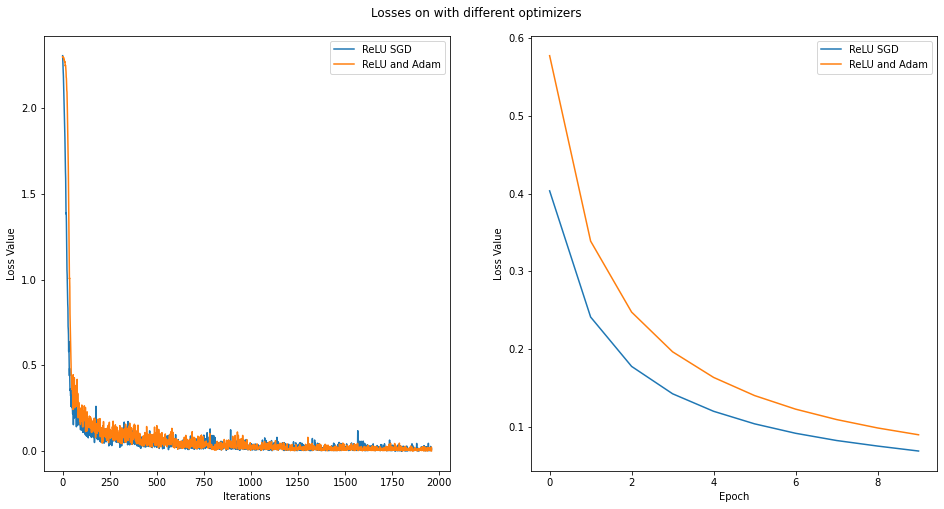

In [110]:
title = 'Losses on with different optimizers'
print_losses(iter_loss_adam, iter_loss_net1_bn, ep_loss_adam, ep_loss_net1_bn, 'ReLU', 'Adam', 'SGD', title)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Thoughts:** 
- In my experiment, ReLU and LeakyReLU showed the best results of achieving minimum loss, both without and with batch normalization. The worst result is SoftPlus. If choosing between the two best, I would prefer LeakyReLU, for the lack of problems with vanishing gradients.
- Batch Normalizstion certainly helps the network to converge to a minimum faster, we can notice this on every activation function's plot. By normalizing the output from the linear layer we get a guarantee that the data to the next layer will most likely come with Mean = 0, Variance = 1. We can change the weights by a larger amount compared to the model without BatchNorm. The presence of Shift+Scale allows us to tune these parameters, adapting them to the next layer. In the backpropagation, the change of the previous layer doesn't "hit the head" of the next layer too much.
- In terms of execution time, ReLU also showed the minimum value. In my experiment SGD optimizer showed a lower loss than Adam, but Adam behaves more stable when learning.


**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [111]:
class DatasetMNIST(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = np.array(X)
        self.y = np.array(y)
        self.transform = transform
        assert (X.shape[0] == y.shape[0])
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        obj = self.X[index]
        label = self.y[index]
        
        if self.transform is not None:
            obj = self.transform(obj)
            
        return obj, label

In [112]:
def MySuperNet():
    MySuperNet = Sequential()
    MySuperNet.add(Flatten())
    MySuperNet.add(Linear(in_features, 256))
    MySuperNet.add(BatchNormalization(0.2))
    MySuperNet[-1].moving_mean = np.zeros(256)
    MySuperNet[-1].moving_variance = np.ones(256)
    MySuperNet.add(ChannelwiseScaling(256))
    MySuperNet.add(ReLU())
    MySuperNet.add(Linear(256, 128))
    MySuperNet.add(BatchNormalization(0.2))
    MySuperNet[-1].moving_mean = np.zeros(128)
    MySuperNet[-1].moving_variance = np.ones(128)
    MySuperNet.add(ChannelwiseScaling(128))
    MySuperNet.add(ReLU())
    MySuperNet.add(Dropout())
    MySuperNet.add(Linear(128, num_classes))
    MySuperNet.add(LogSoftMax())
    return MySuperNet

print(MySuperNet())

Flatten
Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
ReLU
Linear 256 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 128 -> 10
LogSoftMax



In [113]:
# Let's make some augmentations
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(.5, 1.0), ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ToTensor(),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_dataset = DatasetMNIST(X_train, y_train_ohe, transform = train_transforms)
val_dataset = DatasetMNIST(X_val, y_val_ohe, transform = test_transforms)
test_dataset = DatasetMNIST(X_test, y_test_ohe, transform = test_transforms)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [114]:
def train_loop(net, train_loader, val_loader, n_epoch, optimizer, optimizer_config, criterion = ClassNLLCriterion()):
    
    train_loss_history = []
    val_loss_history = []
    optimizer_state = {}
    
    for i in np.arange(n_epoch):
        
        net.train() # turn on dropout and batch_norm training mode
        for X_batch, Y_batch in train_loader:        
            net.zeroGradParameters()    
        # Forward
            predictions = net.forward(X_batch.numpy())
            loss = criterion.forward(predictions, Y_batch.numpy())    
        # Backward
            dp = criterion.backward(predictions, Y_batch.numpy())
            net.backward(X_batch.numpy(), dp)        
        # Update weights
            optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        
            train_loss_history.append(loss)
            
            
        validation_loss = []
        net.evaluate() # turn off dropout and batch_norm training mode
        for X_batch, Y_batch in val_loader:
            predictions = net.forward(X_batch.numpy())
            loss = criterion.forward(predictions, Y_batch.numpy())
            validation_loss.append(loss)
        
        val_loss_history.append(np.mean(validation_loss))
        print(f'Epoch {i + 1} of {n_epoch}')
        
        print(f"\t  training loss: {np.mean(train_loss_history):.6f}")
        print(f"\tvalidation loss: {val_loss_history[-1]:.6f}")

    return train_loss_history, val_loss_history

In [115]:
sgd_momentum_config = {
    "learning_rate" : 1e-2,
    "momentum" : 0.9
}

MSN = MySuperNet()

train_losses, val_losses = train_loop(MSN, train_loader, val_loader, n_epoch, sgd_momentum, sgd_momentum_config)

C:\Users\German\anaconda3\lib\site-packages\torchvision\transforms\functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


Epoch 1 of 10
	  training loss: 2.031581
	validation loss: 1.450782
Epoch 2 of 10
	  training loss: 1.454088
	validation loss: 0.700024
Epoch 3 of 10
	  training loss: 1.140161
	validation loss: 0.477716
Epoch 4 of 10
	  training loss: 0.958620
	validation loss: 0.401068
Epoch 5 of 10
	  training loss: 0.838801
	validation loss: 0.352279
Epoch 6 of 10
	  training loss: 0.753963
	validation loss: 0.320399
Epoch 7 of 10
	  training loss: 0.690705
	validation loss: 0.269801
Epoch 8 of 10
	  training loss: 0.639349
	validation loss: 0.300730
Epoch 9 of 10
	  training loss: 0.598426
	validation loss: 0.279661
Epoch 10 of 10
	  training loss: 0.565289
	validation loss: 0.283239


Minimal train loss:  0.1242
Minimal validate loss:  0.2698


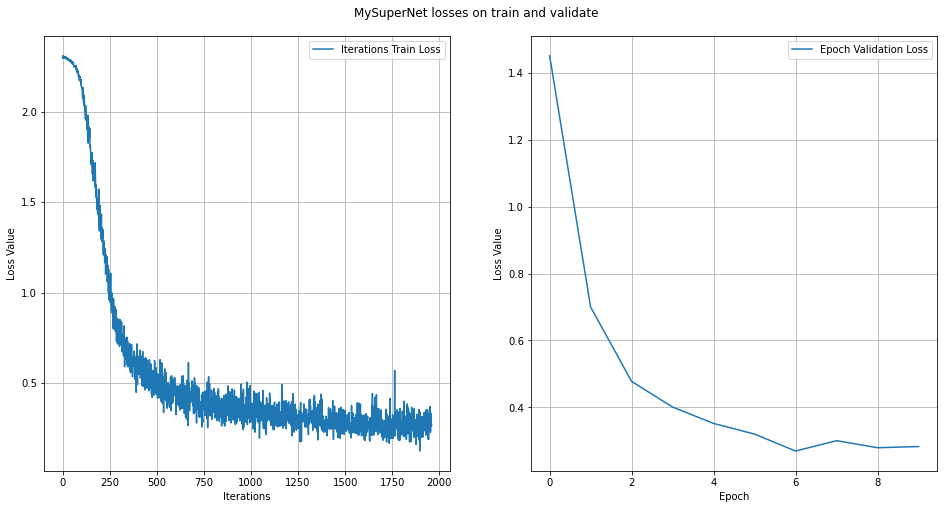

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(16,8));
xlabel = ['Iterations', 'Epoch']
fig.suptitle('MySuperNet losses on train and validate', y=0.93)
ax[0].plot(train_losses, label = 'Iterations Train Loss')
ax[1].plot(val_losses, label = 'Epoch Validation Loss')
for i in range(2):
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel('Loss Value')
    ax[i].grid(which='major')
    ax[i].legend();
print('Minimal train loss: ', round(min(train_losses), 4)) 
print('Minimal validate loss: ', round(min(val_losses), 4))

Print here your accuracy on test set. It should be around 90%.

In [121]:
MSN.evaluate()
y_pred = np.array([])
y_label = np.array([])

for X_batch, Y_batch in test_loader:
    predict = MSN.forward(X_batch.numpy())
    y_pred = np.concatenate((y_pred, predict.argmax(axis=1)))
    y_label = np.concatenate((y_label, Y_batch.numpy().argmax(axis=1)))
    
print("Accuracy on test =", np.mean(y_label == y_pred))

Accuracy on test = 0.9552


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [122]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist1.load_dataset()

In [123]:
#let's redefine transforms and loaders because torch doesn't support one hot
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(.5, 1.0), ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ToTensor(),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_dataset = DatasetMNIST(X_train, y_train, transform = train_transforms)
val_dataset = DatasetMNIST(X_val, y_val, transform = test_transforms)
test_dataset = DatasetMNIST(X_test, y_test, transform = test_transforms)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [124]:
import torchsummary

model = torch.nn.Sequential()
model.add_module('flatten', torch.nn.Flatten())
model.add_module('dense1', torch.nn.Linear(in_features, 256))
model.add_module('dense1_bn', torch.nn.BatchNorm1d(256))
model.add_module('dense1_lrelu', torch.nn.ReLU())
model.add_module('dense2', torch.nn.Linear(256, 128))
model.add_module('dense2_bn', torch.nn.BatchNorm1d(128))
model.add_module('dense2_2relu', torch.nn.ReLU())
model.add_module('dropout2', torch.nn.Dropout())
model.add_module('dense3', torch.nn.Linear(128, num_classes))

torchsummary.summary(model, (28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
       BatchNorm1d-6                  [-1, 128]             256
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.90
Estimated Total Size (MB): 0.92
-------------------------------------------

In [125]:
def train_torch_model(model, train_loader, val_loader, loss_fn, n_epochs, 
                      lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau, lr_scheduler_params: Dict = {}):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    lr_scheduler = lr_scheduler_class(opt, **lr_scheduler_params) #Let's try to use learning rate schedule 
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # turn on dropout and batch_norm training mode
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            
            out = model(X_batch)
            loss = loss_fn(out, y_batch.long())
            
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # turn off dropout and batch_norm training mode
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                out = model(X_batch)
                loss = loss_fn(out, y_batch.long())
                
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum((y_pred.cpu() == y_batch.cpu()).numpy())/len(y_batch.cpu().numpy()))
                
        lr_scheduler.step(loss.item()) #learning rate decay

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [126]:
loss_func = torch.nn.CrossEntropyLoss()

n_epochs = 10
train_loss, val_loss, val_accuracy = train_torch_model(model, train_loader,
                                                 test_loader, loss_func,
                                                 n_epochs)

Epoch 1 of 10 took 13.874s
	  training loss: 1.191694
	validation loss: 0.320241
	validation accuracy: 0.921
Epoch 2 of 10 took 13.745s
	  training loss: 0.646725
	validation loss: 0.241419
	validation accuracy: 0.929
Epoch 3 of 10 took 13.428s
	  training loss: 0.527423
	validation loss: 0.176369
	validation accuracy: 0.949
Epoch 4 of 10 took 13.583s
	  training loss: 0.473649
	validation loss: 0.152321
	validation accuracy: 0.958
Epoch 5 of 10 took 13.978s
	  training loss: 0.431564
	validation loss: 0.134828
	validation accuracy: 0.961
Epoch 6 of 10 took 14.061s
	  training loss: 0.402300
	validation loss: 0.134290
	validation accuracy: 0.960
Epoch 7 of 10 took 14.171s
	  training loss: 0.384678
	validation loss: 0.109845
	validation accuracy: 0.968
Epoch 8 of 10 took 13.971s
	  training loss: 0.365082
	validation loss: 0.113388
	validation accuracy: 0.968
Epoch 9 of 10 took 14.002s
	  training loss: 0.357393
	validation loss: 0.104084
	validation accuracy: 0.969
Epoch 10 of 10 took

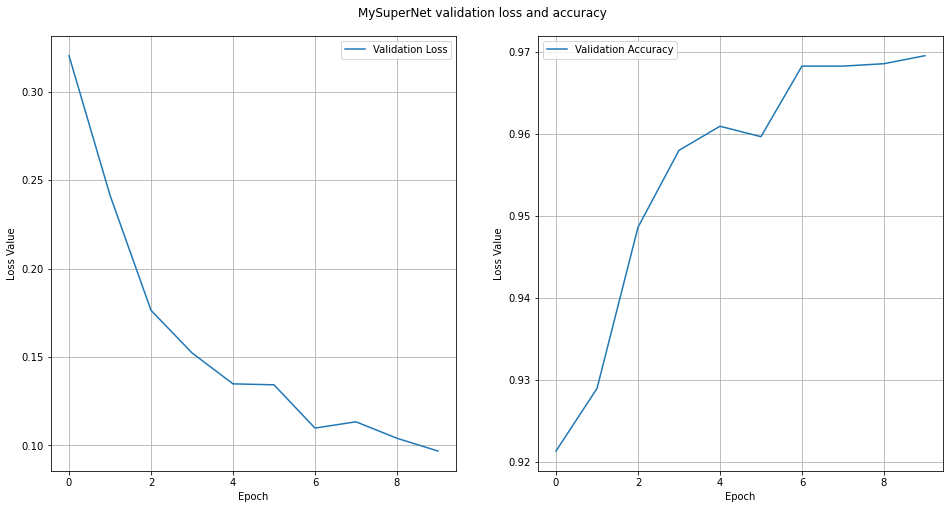

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(16,8));
fig.suptitle('MySuperNet validation loss and accuracy', y=0.93)
ax[0].plot(val_loss, label = 'Validation Loss')
ax[1].plot(val_accuracy, label = 'Validation Accuracy')
for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Loss Value')
    ax[i].grid(which='major')
    ax[i].legend();

In [129]:
with torch.no_grad():
    model.train(False)

    y_pred = np.array([])
    y_label = np.array([])

    for X_batch, y_batch in test_loader:
        out = model.forward(X_batch)

        y_pred = np.concatenate((y_pred, out.numpy().argmax(axis=1)))
        y_label = np.concatenate((y_label, y_batch.numpy()))

    print("Accuracy on test = ", np.mean(y_label == y_pred))

Accuracy on test =  0.9688


Accuracy on our self-made net and the Torch model is almost the same, it's a success!